# Model PC 

Model PC is introduced in chapter 4 of {cite:t}`GodleyLavoie2006MonetaryEconomicsIntegrated` "Monetary Economics: An Integrated Approach to Credit, Money, Income, Production and Wealth".

## Module Contents

As with all `MacroStat` models, PC is divided into Variables, Parameters (fixed constants), Scenarios, and the Behavior (model initialization and steps). The module-level documentation, such as all variables/parameters/scenarios and their notation or the behavioral equations associated with each function of `BehaviorPC.py` can be seen in:

```{eval-rst}
.. toctree::
    :maxdepth: 2

    Variables <GL06PC/variables.rst>
    Parameters <GL06PC/parameters.rst>
    Equations <GL06PC/equations.rst>
    Scenarios <GL06PC/scenarios.rst>
```

The remainder of this page gives an introduction to the model, notes on how it is implemented in `MacroStat` and then shows some of the model dynamics by replicating the relevant graphs of Godley and Lavoie (2006).

## Model Overview

### Transaction Flow Matrix

```{csv-table} Accounting Transaction Matrix for Model PC
:file: GL06PC/transaction_matrix.csv
:header-rows: 2
:stub-columns: 1
```

### Balance Sheet Matrix

```{csv-table} Balance Sheet for Model PC
:file: GL06PC/balance_sheet.csv
:header-rows: 2
:stub-columns: 1
```

## Implementation in MacroStat

Transposing these eleven equations to the `MacroStat` framework, we consider that there are:

1. Three parameters (fixed constants): $\alpha_1$, $\alpha_2$, and $\theta$ (see [Parameters](GL06PC/parameters.rst))
2. Two scenario variables : $G_d(t)$ and $W(t)$ (see [Scenarios](GL06PC/scenarios.rst))
3. The remaining 14 tracked series are variables (see [Variables](GL06PC/variables.rst))

### Behavioral Modeling

The model PC imposes that the assumptions of the household on income are correct and firms supply all goods. For the implementation of the behavioral equations (see [Behavior](GL06PC/behavior.rst)), most prior implementations have made use of some form of linear solver or iteration until the system is solved. To simplify the implementation in Macrostat, we can note that the system can be solved analytically for a given timestep as follows:

Substitute the consumption equation into the national income equation to obtain
```{math}
Y(t) = \alpha_1 YD(t) + \alpha_2 V(t-1) + G(t)
```
where $G(t)$ is exogenous and $V(t-1)$ is determined. Substituting further the disposable income equation and tax equation we can obtain
```{math}
Y(t) = \alpha_1(1-\theta)\left(Y(t) + r(t-1)B_h(t-1)\right) + \alpha_2 V(t-1) + G(t)
```
which can be rearranged to yield a solution for $Y(t)$
```{math}
:label: gl06_pc_analyticalSolutionY
Y(t) = \frac{\alpha_1(1-\theta)r(t-1)B_h(t-1) + \alpha_2 V(t-1) + G(t)}{1 - \alpha_1(1-\theta)}
```

Therefore, for a given period $t$ we can solve the system by solving, in order:
1. Eq. {eq}`gl06_pc_analyticalSolutionY` for national income $Y(t)$
2. Eq. {eq}`gl06_pc_eq403_taxes` for taxes $T(t)$
3. Eq. {eq}`gl06_pc_eq402_disposableIncome` for disposable income $YD(t)$
4. Eq. {eq}`gl06_pc_eq405_consumption` for consumption $C(t)$
5. Eq. {eq}`gl06_pc_eq404_wealth` for wealth $V(t)$
6. Eq. {eq}`gl06_pc_eq407_householdBondHoldings` for household bill holdings $B_h(t)$
7. Eq. {eq}`gl06_pc_eq406_householdDeposits` for household depositis (residual) $H_h(t)$
8. Eq. {eq}`gl06_pc_eq408_governmentBillIssuance` for the government budget resulting in bill issuance $B_s(t)$
9. Eq. {eq}`gl06_pc_eq410_centralBankBills` for the Central Bank holding of bills $B_{CB}(t)$
10. Eq. {eq}`gl06_pc_eq409_moneyIssuance` for the level of cash money $H_s(t)$

This is implemented as such in the [Behavior](GL06SIM/behavior.rst) class. 

## Model Dynamics

### Preparatory Steps

In [1]:
%load_ext autoreload
%autoreload 2

import importlib
import logging
import sys

# Import the necessary libraries for plotting
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter

# Import the MacroStat get_model function
from macrostat.models import get_model

# Custom matplotlib style for the documentation
plt.style.use("../../macrostat.mplstyle")
# We show the logging output in the notebook
importlib.reload(logging)
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

### Running the Simulation

First, we can run the model without any shocks to see the convergence to the steady state.

In [2]:
GL06PCClass = get_model("GL06PC")
model = GL06PCClass()
model.simulate()
output = model.variables.to_pandas()

INFO:root:Starting simulation. Scenario: 0


Here we can also check that the variables are healthy, which means that the redundant equations hold and that all the assets and liabilities are positive. For model PC, the redundant equation is that the household money stock equals the central bank money stock. 

:::{Note}
In numerical implementations, due to floating point precision it is unlikely that the redundant equation will hold exactly. Therefore, we check that the absolute percentage error is less than a given tolerance, in this case 1e-5. We use the absolute percentage error to appropriately scale the error for different magnitudes of the variables.
:::

In [3]:
model.variables.check_health(tolerance=1e-5)

True

### Convergence to the Steady State

Following the derivations of section 4.5 in {cite:t}`GodleyLavoie2006MonetaryEconomicsIntegrated`, we compute the steady state as

```{math}
\begin{align}
G^\star(t) &= G(t)\\
r^\star(t) &= r(t)\\
\alpha_3 &= \frac{1-\alpha_1}{\alpha_2}\\
YD^\star(t) &= \frac{G^\star(t)}{\frac{\theta}{1-\theta} - r^\star(t)\cdot\left(\left(\lambda_0 + \lambda_1 r^\star(t) \right)\alpha_3 - \lambda_2\right)}\\
C^\star(t) &= YD^\star(t)\\
Y^\star(t) &= C^\star(t) + G^\star(t)\\
V^\star(t) &= \alpha_3 YD^\star(t)\\
B_h^\star(t) &= \left(\left(\lambda_0 + \lambda_1 r^\star(t) \right)\alpha_3 - \lambda_2\right)\cdot YD^\star(t)\\
T^\star(t) &= \theta\cdot \left(Y^\star(t) + r^\star(t) B_h^\star(t)\right)\\
H_h^\star(t) &= V^\star(t) - B_h^\star(t)\\
B_s^\star(t) &= \frac{r^\star(t) B_{CB}^\star(t) + T^\star(t) - G^\star(t)}{r^\star(t)}\\
B_{CB}^\star(t) &= B_s^\star(t) - B_h^\star(t)\\
H_s^\star(t) &= H_{s}(t-1) + (B_{CB}(t) - B_{CB}(t-1))
\end{align}
```

In [4]:
model.compute_theoretical_steady_state(scenario=0)
steadystate = model.variables.to_pandas()

INFO:root:Computing theoretical steady state. Scenario: 0


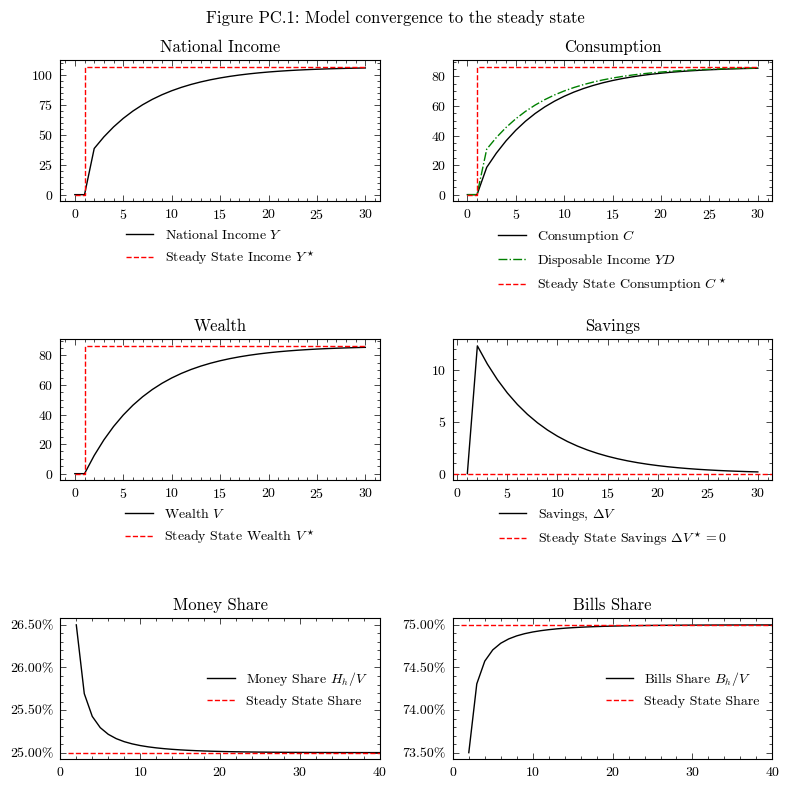

In [5]:
dfo = output.loc[:30]
dfs = steadystate.loc[:30]

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(8, 8))

# National Income and Consumption
axs[0,0].plot(dfo.index, dfo['NationalIncome'], color='k', label=r'National Income $Y$')
axs[0,0].step(x=dfs.index,y=dfs["NationalIncome"], color='r', linestyle='--', label=r'Steady State Income $Y^\star$')
axs[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[0,0].set_title('National Income')
axs[0,1].plot(dfo.index, dfo['ConsumptionHousehold'], color='k', label=r'Consumption $C$')
axs[0,1].plot(dfo.index, dfo['DisposableIncome'], color='g', linestyle='-.', label=r'Disposable Income $YD$')
axs[0,1].step(x=dfs.index,y=dfs["ConsumptionHousehold"], color='r', linestyle='--', label=r'Steady State Consumption $C^\star$')
axs[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[0,1].set_title('Consumption')

# Wealth and Savings
axs[1,0].plot(dfo.index, dfo['Wealth'], color='k', label=r'Wealth $V$')
axs[1,0].step(x=dfs.index,y=dfs["Wealth"], color='r', linestyle='--', label=r'Steady State Wealth $V^\star$')
axs[1,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[1,0].set_title('Wealth')
axs[1,1].plot(dfo.index, dfo['Wealth'].diff(), color='k', label=r'Savings, $\Delta V$')
axs[1,1].axhline(y=0, color='r', linestyle='--', label=r'Steady State Savings $\Delta V^\star=0$')
axs[1,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), frameon=False)
axs[1,1].set_title('Savings')

# Money Share and Bills Share
share_bills = steadystate['HouseholdBillStock'] / steadystate['Wealth']
axs[2,0].plot(output.index, output['HouseholdMoneyStock'] / output['Wealth'], color='k', linestyle='-', label='Money Share $H_h/V$')
axs[2,0].step(x=share_bills.index,y=1-share_bills, color='r', linestyle='--', label='Steady State Share')
axs[2,0].legend(loc='center right', frameon=False)
axs[2,0].set_xlim(0,40)
axs[2,0].set_title('Money Share')
axs[2,0].yaxis.set_major_formatter(PercentFormatter(1))

# Right panel - Bills share
axs[2,1].plot(output.index, output['HouseholdBillStock'] / output['Wealth'], color='k', linestyle='-', label='Bills Share $B_h/V$')
axs[2,1].step(x=share_bills.index,y=share_bills, color='r', linestyle='--', label='Steady State Share')
axs[2,1].legend(loc='center right', frameon=False)
axs[2,1].set_xlim(0,40)
axs[2,1].set_title('Bills Share')
axs[2,1].yaxis.set_major_formatter(PercentFormatter(1))


fig.suptitle('Figure PC.1: Model convergence to the steady state')
plt.tight_layout()
plt.show()
